In [1]:
import numpy as np
import pandas as pd



In [76]:
# Считываем входные данные
data = pd.read_csv('input.csv', skipinitialspace=True)
data['prev'] = data['prev'].fillna(value='-')
data

,name,duration,prev
0,w0,15,-
1,w1,9,-
2,w2,12,-
3,w3,11,0 1
4,w4,17,0 1
5,w5,6,0
6,w6,16,3 4 5
7,w7,16,4 5 2
8,w8,10,6 7
9,w9,5,7


In [71]:
# Листы, куда будем складывать входные и выходные точки
inputs_list = []
outputs_list = []

# Формируем граф в виде матрицы смежности
# Где нет ребра, там -1
# Нулевая вершина - начало, последняя - конец
# Для i-й работы начало - 2i+1, конец 2i+2
adj_matr = np.full([data.shape[0]*2 + 2, data.shape[0]*2 + 2], -1)
for idx, [name, duration, prev_str] in data.iterrows():
    # Работа - ребро между своим началом и концом
    adj_matr[idx*2+1, idx*2+2] = duration
    # Если нет предыдущих, то это начало работы - вход
    if prev_str == '-':
        inputs_list.append(idx*2+1)
        adj_matr[0, idx*2+1] = 0;
    # Иначе связываем концы предыдущих работ с началом этой
    else:
        for i_str in prev_str.split():
            i = int(i_str)
            adj_matr[i*2+2, idx*2+1] = 0
            
# Проходимся по концам работ, если нет дуги - это выход
for idx in range(1, data.shape[0]):
    if np.all(adj_matr[idx*2+2] == -1):
        outputs_list.append(idx*2+2)
        adj_matr[idx*2+2, -1] = 0;
        
print('Входные вершины:', inputs_list)
print('Выходные вершины:', outputs_list)

Входные вершины: [1, 3, 5]
Выходные вершины: [18, 20]


In [72]:
print(adj_matr)

[[-1  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 12 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 16 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [77]:
# К этому моменту граф должен быть топологически отсортирован
# Т.е. все дуги выходят из вершин с меньшими индексами
# И входят в вершины с большими


# Проходим от начала до конца, находим максимальные пути
distances = np.full(data.shape[0]*2 + 2, -1)
distances[0] = 0;
# Смотрим по очереди все вершины
for i in range(data.shape[0]*2 + 2):
    # Путь до текущей берем как максимальную сумму
    # предыдущего пути + ребра
    for j in range(i):
        if (adj_matr[j, i] != -1) and (distances[j] + adj_matr[j, i] > distances[i]):
            distances[i] = distances[j] + adj_matr[j, i]

# dist_forward_df = pd.DataFrame({'vertex' : range(distances.shape[0]), 'max distance' : distances})
# dist_forward_df['max distance']
print(distances)

[ 0  0 15  0  9  0 12 15 26 15 32 15 21 32 48 32 48 48 58 48 53 58]


In [78]:
# Проходим из конца в начало
# Смотрим по очереди все вершины
distances_b = np.full(data.shape[0]*2 + 2, distances[-1])
for i in reversed(range(data.shape[0]*2 + 2)):
    # Путь до текущей берем как минимум
    # предыдущего пути и ребра
    for j in range(i, data.shape[0]*2 + 2):
        if (adj_matr[i, j] != -1) and (distances[j] - adj_matr[i, j] < distances_b[i]):
            distances_b[i] = distances_b[j] - adj_matr[i, j]
            
# dist_backward_df = pd.DataFrame({'vertex' : range(distances_b.shape[0]), 'max distance' : distances_b})
# dist_backward_df['max distance']
print(distances_b)

[ 0  0 15  6 15 20 32 21 32 15 32 26 32 32 48 32 48 48 58 53 58 58]


In [74]:
# Выходные данные
e_sf = distances[1: -1].reshape([data.shape[0], 2])
l_sf = distances_b[1: -1].reshape([data.shape[0], 2])

out = pd.DataFrame({'name' : data['name'],
                    'duration' : data['duration'],
                    'early start' : e_sf[:, 0],
                    'late start' : l_sf[:, 0],
                    'early finish' : e_sf[:, 1],
                    'late finish' : l_sf[:, 1],
                    'time margin' : l_sf[:, 0] - e_sf[:, 0]})

out.to_csv('out.csv', index=False)
out

,name,duration,early start,late start,early finish,late finish,time margin
0,w0,15,0,0,15,15,0
1,w1,9,0,6,9,15,6
2,w2,12,0,20,12,32,20
3,w3,11,15,21,26,32,6
4,w4,17,15,15,32,32,0
5,w5,6,15,26,21,32,11
6,w6,16,32,32,48,48,0
7,w7,16,32,32,48,48,0
8,w8,10,48,48,58,58,0
9,w9,5,48,53,53,58,5


In [75]:
# Критический путь
crit_path_full = out[out['early start'] == out['late start']]
crit_path = pd.DataFrame({'name' : crit_path_full['name'],
                          'duration' : crit_path_full['duration'],
                          'start' : crit_path_full['early start'],
                          'finish' : crit_path_full['early finish']})

crit_path.to_csv('crit_path.csv', index=False)
crit_path

,name,duration,start,finish
0,w0,15,0,15
4,w4,17,15,32
6,w6,16,32,48
7,w7,16,32,48
8,w8,10,48,58


In [36]:
# Теперь обход вширь от начала до конца
# Находим ранние начала и окончания

# Формируем список смежности
adj_list = {}
for idx, row in enumerate(adj_matr):
    adj_list[idx] = row[row != -1]
    
adj_list

{0: array([15]),
 1: array([0, 0, 0]),
 2: array([9]),
 3: array([0, 0]),
 4: array([12]),
 5: array([0]),
 6: array([11]),
 7: array([0]),
 8: array([17]),
 9: array([0, 0]),
 10: array([6]),
 11: array([0, 0]),
 12: array([16]),
 13: array([0]),
 14: array([16]),
 15: array([0, 0]),
 16: array([10,  0]),
 17: array([], dtype=int32),
 18: array([5, 0]),
 19: array([], dtype=int32),
 20: array([], dtype=int32),
 21: array([0, 0, 0])}

In [37]:
# Сам обход

dist = np.full(adj_matr.shape[0], -1)
beg_idx = adj_matr.shape[0] - 1
dist[beg_idx] = 0
queue = [beg_idx]
while queue:
    curr = queue.pop()
    for to in adj_list[curr]:
        if dist[to] == -1:
            queue.append(to)
            dist[to] == dist[curr] + 1

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1])

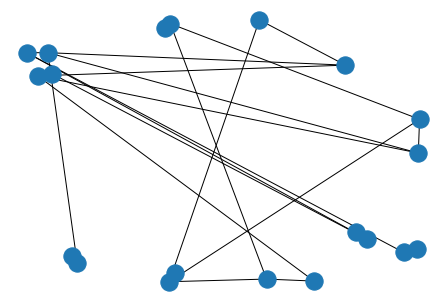

In [23]:
# Визаулизируем граф

import networkx as nx

vis_graph = nx.from_numpy_matrix(adj_matr)
nx.draw(vis_graph)